In [23]:
# this code uses a PYNQ overlay to sum every pair of numbers in an array of uint16.
#The array can be arbitrarily long.
#Sadly, this example does not quite show the PL (programmable logic) being faster than the CPU;
#Hopefully, convolving with large filters should see a speedup in the programmable logic over running on the CPU.
#Although also note: PL is currently limited by AXI bus speed (currently 50MHz)

#Tean: Arthur Wang / Ian Wu / Jiachen Zhang

import numpy as np
import pynq
import time
import matplotlib.pyplot as plt

cpu does sums in 0.159 seconds
programmable logic does sums in 0.00148 seconds
Number of e > 0:  13585
Number of e > 4:  10959
Number of e > 16:  5276
Number of e > 64:  97
Number of e > 256:  0


In [ ]:
#load overlay, as we did for GPIO.
overlay = pynq.Overlay("dma_tutorial.bit")
# print(overlay.ip_dict)
dma_toPL = overlay.axi_dma_from_ps_to_pl
dma_fromPL = overlay.axi_dma_from_pl_to_ps

n = 64
delay = 4224
w1_data = np.random.randint(low=-65536, high=65535, size=(n,n), dtype=np.int32)
w2_data = np.random.randint(low=-65536, high=65535, size=(n,n), dtype=np.int32)
w3_data = np.random.randint(low=-65536, high=65535, size=(n,n), dtype=np.int32)
x_data = np.random.randint(low=-65536, high=65535, size=(n,n), dtype=np.int32)
dy_data = np.random.randint(low=-65536, high=65535, size=(n,n), dtype=np.int32)

dma_data = np.concatenate((np.array([n*n*9+delay*8+2*17+2, 0x06410000 | (n*n*4), 0x064201ff]),
                           np.array([0x06400000 | n*n, 0x02]), w1_data.flatten(),
                           np.array([0x06400000 | n*n, 0x42]), w2_data.flatten(),
                           np.array([0x06400000 | n*n, 0x12]), w3_data.flatten(),
                           np.array([0x06400000 | n*n, 0x52]), x_data.flatten(),
                           np.array([0x06400000 | delay, 0x00962501]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | delay, 0x00c66241]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | delay, 0x0086d611]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | n*n, 0x182]), dy_data.flatten(),
                           np.array([0x06400000 | delay, 0x010cc811]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | delay, 0x02001681]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | delay, 0x010c9c41]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | delay, 0x020042c1]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | delay, 0x02000591]), np.zeros(delay, dtype=np.int32),
                           np.array([0x06400000 | n*n, 0xd3]), np.zeros(n*n, dtype=np.int32),
                           np.array([0x06400000 | n*n, 0x03]), np.zeros(n*n, dtype=np.int32),
                           np.array([0x06400000 | n*n, 0x43]), np.zeros(n*n, dtype=np.int32),
                           np.array([0x06400000 | n*n, 0x13]), np.zeros(n*n, dtype=np.int32),))

#see how long it takes CPU processing to do operation
start_time = time.time()

x_arr = x_data/65536
w1_arr = w1_data/65536
w2_arr = w2_data/65536
w3_arr = w3_data/65536
dy_arr = dy_data/65536

a1_arr = np.maximum(np.matmul(w1_arr, x_arr), 0)
a2_arr = np.maximum(np.matmul(w2_arr, a1_arr), 0)
y_arr = np.maximum(np.matmul(w3_arr, a2_arr), 0)

b1_arr = np.zeros((n,n))
b2_arr = np.zeros((n,n))
b3_arr = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        b1_arr[i,j] = a1_arr[i,j] > 0
        b2_arr[i,j] = a2_arr[i,j] > 0
        b3_arr[i,j] = y_arr[i,j] > 0

p3 = dy_arr * b3_arr
p2 = np.matmul(np.transpose(w3_arr),p3) * b2_arr
w3_arr_n = w3_arr + np.matmul(p3, np.transpose(a2_arr))
p1 = np.matmul(np.transpose(w2_arr),p2) * b1_arr 
w2_arr_n = w2_arr + np.matmul(p2, np.transpose(a1_arr))
w1_arr_n = w1_arr + np.matmul(p1, np.transpose(x_arr))

expected_output = np.int32(np.concatenate((y_arr,w1_arr_n,w2_arr_n,w3_arr_n,))*65536).flatten()

cputime = time.time() - start_time
print("cpu does sums in %.3f seconds"%cputime)
    
#set up PYNQ data arrays (can be used as numpy arrays, but include physical memory addresses for DMA access)
data1 = pynq.allocate(shape=(len(dma_data),), dtype=np.uint32)
data2 = pynq.allocate(shape=(len(expected_output),), dtype=np.uint32)
data3 = pynq.allocate(shape=(len(expected_output),), dtype=np.uint32)
np.copyto(data1, dma_data, 'unsafe')
np.copyto(data3, expected_output, 'unsafe')

#execute and time operation in programmable logic
# start_time = time.time()
dma_toPL.sendchannel.transfer(data1)
dma_fromPL.recvchannel.transfer(data2)
start_time = time.time()
dma_toPL.sendchannel.wait()
dma_fromPL.recvchannel.wait()
pltime = time.time()-start_time
print("programmable logic does sums in %.5f seconds"%pltime)

print("Number of e > 0: ", np.sum(np.absolute(np.int32(data3)-np.int32(data2))>0))
print("Number of e > 4: ", np.sum(np.absolute(np.int32(data3)-np.int32(data2))>4))
print("Number of e > 16: ", np.sum(np.absolute(np.int32(data3)-np.int32(data2))>16))
print("Number of e > 64: ", np.sum(np.absolute(np.int32(data3)-np.int32(data2))>64))
print("Number of e > 256: ", np.sum(np.absolute(np.int32(data3)-np.int32(data2))>256))

np.set_printoptions(formatter={'int':hex})


129
-108


(0, 500)

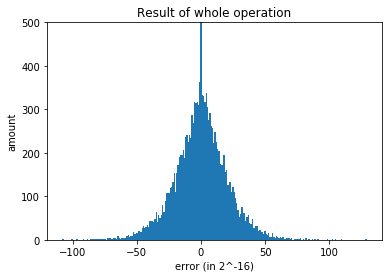

In [41]:
print(np.amax(np.int32(data3) - np.int32(data2)))
print(np.amin(np.int32(data3) - np.int32(data2)))
plt.hist(np.int32(data3)-np.int32(data2), 238)
plt.title("Result of whole operation")
plt.xlabel("error (in 2^-16)")
plt.ylabel("amount")
plt.ylim(0,500)

129
-108


Text(0,0.5,'amount')

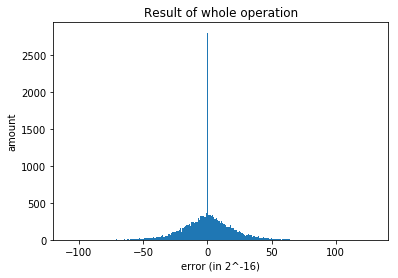

In [42]:

print(np.amax(np.int32(data3) - np.int32(data2)))
print(np.amin(np.int32(data3) - np.int32(data2)))
plt.hist(np.int32(data3)-np.int32(data2), 238)
plt.title("Result of whole operation")
plt.xlabel("error (in 2^-16)")
plt.ylabel("amount")

In [55]:
data = np.int32(data3) - np.int32(data2)
ydata = data[0:4096]
w1data=data[4096:8192]
w2data=data[8192:12288]
w3data=data[12288:16384]
by = 1+np.amax(ydata)-np.amin(ydata)
bw1 = 1+np.amax(w1data)-np.amin(w1data)
bw2 = 1+np.amax(w2data)-np.amin(w2data)
bw3 = 1+np.amax(w3data)-np.amin(w3data)

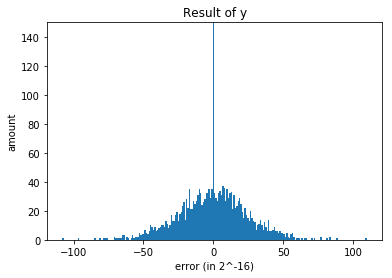

In [73]:
plt.hist(ydata, by)
plt.title("Result of y")
plt.xlabel("error (in 2^-16)")
plt.ylabel("amount")
plt.ylim(0,150)
plt.savefig('y.png')

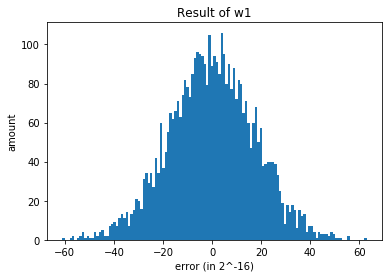

In [69]:
plt.hist(w1data, bw1)
plt.title("Result of w1")
plt.xlabel("error (in 2^-16)")
plt.ylabel("amount")
# plt.ylim(0,110)
plt.savefig('w1.png')

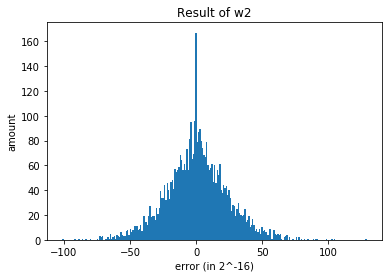

In [70]:
plt.hist(w2data, bw2)
plt.title("Result of w2")
plt.xlabel("error (in 2^-16)")
plt.ylabel("amount")
# plt.ylim(0,150)
plt.savefig('w2.png')

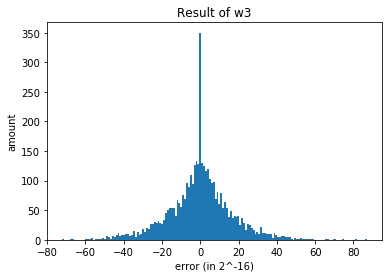

In [71]:
plt.hist(w3data, bw3)
plt.title("Result of w3")
plt.xlabel("error (in 2^-16)")
plt.ylabel("amount")
# plt.ylim(0,150)
plt.savefig('w3.png')